# Predict user car sale price

# 1. Setup

In [2]:
# imports
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


2.6.2


In [3]:
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

## load model data

In [4]:
# load car price data set 
with open('./df_model.pkl', 'rb') as handle:
    df = pickle.load(handle)
df.shape

(33956, 88)

In [5]:
# examine
df.head(2)

,price,year,classic_car,modern_car,antique_car,acura,alfa-romeo,aston-martin,audi,bmw,...,coupe,hatchback,mini-van,offroad,other_type,pickup,sedan,truck,van,wagon
21171,16990.0,2018,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21174,11975.0,2003,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# convert to a numpy matrix
dataset = df.values
dataset[:3]


array([[16990.,  2018.,     0.,     1.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     1.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     1.,     0.,     0.,     0.,     0.,     0.,     1.,
            0.,     0.,     0.,     1.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     1.,
            0.,     1.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     1.,     0.,     0.,     0.],
       [11975.,  2003.,     0.,     1.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     1.,     0.,     0.,

In [7]:
# split into input (X) and output (Y) variables
X = dataset[:,1:87]
y = dataset[:,0]

In [8]:
print(X)

[[2018.    0.    1. ...    1.    0.    0.]
 [2003.    0.    1. ...    0.    0.    0.]
 [2003.    0.    1. ...    0.    1.    0.]
 ...
 [2017.    0.    1. ...    0.    0.    0.]
 [2015.    0.    1. ...    0.    0.    0.]
 [2011.    0.    1. ...    1.    0.    0.]]


In [9]:
print(y)

[16990. 11975. 21950. ... 31990. 14590. 32990.]


In [18]:
print(f"test sample size: {len(y)}")

test sample size: 33956


In [10]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42) 

### Examine data set

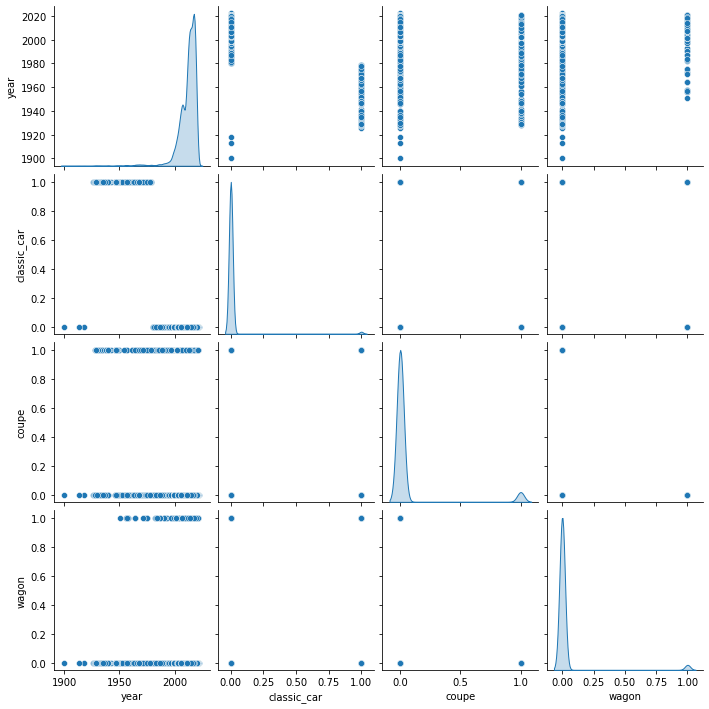

In [11]:
sns.pairplot(df[['year', 'classic_car', 'coupe', 'wagon']], diag_kind='kde')

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,33956.0,18930.331193,13327.101113,100.0,8950.0,15998.0,26590.0,99999.0
year,33956.0,2011.641242,8.531069,1900.0,2008.0,2014.0,2017.0,2022.0
classic_car,33956.0,0.013694,0.116220,0.0,0.0,0.0,0.0,1.0
modern_car,33956.0,0.986217,0.116589,0.0,1.0,1.0,1.0,1.0
antique_car,33956.0,0.000088,0.009399,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
pickup,33956.0,0.128932,0.335129,0.0,0.0,0.0,0.0,1.0
sedan,33956.0,0.303275,0.459680,0.0,0.0,0.0,1.0,1.0
truck,33956.0,0.070179,0.255452,0.0,0.0,0.0,0.0,1.0
van,33956.0,0.027094,0.162359,0.0,0.0,0.0,0.0,1.0


In [13]:
df.describe().transpose()[['mean', 'std']]

,mean,std
price,18930.331193,13327.101113
year,2011.641242,8.531069
classic_car,0.013694,0.116220
modern_car,0.986217,0.116589
antique_car,0.000088,0.009399
...,...,...
pickup,0.128932,0.335129
sedan,0.303275,0.459680
truck,0.070179,0.255452
van,0.027094,0.162359


# 2. Define Baseline Neural Network Model

In [14]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(86, 
                    input_dim=86, 
                    kernel_initializer='normal', 
                    activation='relu'))
#     model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, 
                    kernel_initializer='normal'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [15]:
# compile the network
estimator = KerasRegressor(build_fn=baseline_model,
                           epochs=100, 
                           batch_size=5, 
                           verbose=0)

In [16]:
# add crossvalidation
kfold = KFold(n_splits=10)

In [17]:
# fit and evaluate model
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-06-23 15:20:12.634 tensorflow-2-6-gpu--ml-g4dn-xlarge-0201d392adbb6351f674da89d00b:918 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-06-23 15:20:12.662 tensorflow-2-6-gpu--ml-g4dn-xlarge-0201d392adbb6351f674da89d00b:918 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Baseline: -75076382.40 (3149881.55) MSE
